<a href="https://colab.research.google.com/github/Gr-30/DL/blob/main/image_captioning_5_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning using LSTM on Flickr8K dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
% cd drive/MyDrive/Mtech\ DSE\ BITS/Sem3/DL/Assignment2/

/content/drive/.shortcut-targets-by-id/1i3MOJ7G3hDrf8n5aCrWEPA_DWlB9xWkj/MtechDSEBITS/Sem3/DL/Assignment2


In [3]:
! pip install fast_ml

## Downloading Data and Dependencies

In [4]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2
from fast_ml.model_development import train_valid_test_split
import matplotlib.image as mpimg
import tensorflow as tf


## Data Visualization and Preprocessing

In [5]:
set4 = pickle.load(open('set_4.pkl','rb'))
image_list = os.listdir('Flicker8k_Dataset/')

In [6]:
split_caption = [line.split('\t') for line in set4] 
split = [i[0].split('#') + [i[1]] for i in split_caption]
index_df = pd.DataFrame(split, columns=['img_name','img_id','img_caption'])

In [7]:
imagedata_set4intersect = np.intersect1d(np.array(image_list), index_df.img_name)
index_df = index_df[index_df['img_name'].isin(imagedata_set4intersect)].copy()
index_df['ImageNameWithPath'] = 'Flicker8k_Dataset/'+index_df['img_name']

In [8]:
index_df.head()

,img_name,img_id,img_caption,ImageNameWithPath
0,3312779887_7682db7827.jpg,4,A snowboarder do a trick off of a yellow pyram...,Flicker8k_Dataset/3312779887_7682db7827.jpg
1,2766926202_4201bf2bf9.jpg,2,Two man be play with glow stick and sparkler .,Flicker8k_Dataset/2766926202_4201bf2bf9.jpg
2,244760301_5809214866.jpg,4,Several hiker walk along a rocky path .,Flicker8k_Dataset/244760301_5809214866.jpg
3,97105139_fae46fe8ef.jpg,4,Two person with head covering stand in a sandy...,Flicker8k_Dataset/97105139_fae46fe8ef.jpg
4,2646046871_c3a5dbb971.jpg,3,A child jump in the air with his or her shirt ...,Flicker8k_Dataset/2646046871_c3a5dbb971.jpg


In [9]:
#just checking the number of images in the dataset
print(index_df.shape[0])

24996


In [10]:
#converting the text files to pandas dataframe
image_tokens = index_df[["img_name","img_caption"]]
index_df['dummy'] = 0
train_image_names, dummy_train, val_image_names, dummy_val, test_image_names, dummy_test = train_valid_test_split(index_df, target='dummy', train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42)
train_image_names = train_image_names[['img_name']]
test_image_names = test_image_names[['img_name']]
val_image_names = val_image_names[['img_name']]

In [11]:
#just checking the number of images in the dataset
print(len(image_list))

8091


In [12]:
def displayImageWithCaption(imgWithPath):
  img = mpimg.imread(imgWithPath)
  imgplot = plt.imshow(img)
  print('Captions:',index_df[index_df['ImageNameWithPath']==imgWithPath]['img_caption'].values)
  print('Image:')
  plt.show()

Captions: ['Four woman dress up in funny costume .'
 'Four woman pose in their alien costume .'
 'Four woman dress in costume , one with a pink wig , look to the left .'
 'A group of woman dress as character from star treck .'
 'Three woman wear wig .']
Image:


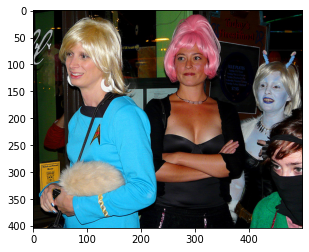

Captions: ['Three man sit at a counter in a restaurant .']
Image:


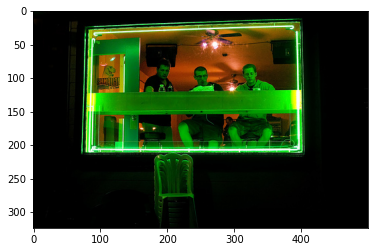

In [13]:
imagesToDisplay = index_df['ImageNameWithPath'].value_counts()[[0,-1]].index
displayImageWithCaption(imagesToDisplay[0])
displayImageWithCaption(imagesToDisplay[1])

In [14]:
# #removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_name"] = image_tokens["img_name"].map(lambda x: ".".join(x.split('.')[:2]))


In [15]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [16]:
#head of the image_tokens dataframe
image_tokens.head()

,img_name,img_caption
0,3312779887_7682db7827.jpg,<start> A snowboarder do a trick off of a yell...
1,2766926202_4201bf2bf9.jpg,<start> Two man be play with glow stick and sp...
2,244760301_5809214866.jpg,<start> Several hiker walk along a rocky path ...
3,97105139_fae46fe8ef.jpg,<start> Two person with head covering stand in...
4,2646046871_c3a5dbb971.jpg,<start> A child jump in the air with his or he...


In [17]:
#head of the train_image_names dataframe
train_image_names.head()

,img_name
13483,2344699642_4fae2f4e07.jpg
22057,2369248869_0266760c4a.jpg
1020,3135826945_f7c741e5b7.jpg
12646,781118358_19087c9ec0.jpg
1533,2066271441_1f1f056c01.jpg


### Creating dictionaries to map image_id and their corresponding captions

In [18]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_name"]==train_image_names["img_name"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_name"].iloc[i]]=l

100%|██████████| 19996/19996 [00:36<00:00, 545.26it/s]


In [19]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_name"]==test_image_names["img_name"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_name"].iloc[i]]=l

100%|██████████| 2500/2500 [00:04<00:00, 525.51it/s]


In [20]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_name"]==val_image_names["img_name"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_name"].iloc[i]]=l

100%|██████████| 2500/2500 [00:05<00:00, 499.57it/s]


### ResNet50 model for encoding images

In [21]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [22]:
#extracting image encodings(features) from resnet50 and forming dict train_features
# path="Flicker8k_Dataset/"
# train_features={}
# c=0
# for image_name in tqdm(train_captions):
#   img_path=path+image_name
#   img=image.load_img(img_path,target_size=(224,224))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)
#   x = preprocess_input(x)
#   features = model.predict(x)
#   train_features[image_name]=features.squeeze()

In [23]:
# with open( "train_encoded_images.p", "wb" ) as pickle_f:
#     pickle.dump(train_features, pickle_f )
with open( "train_encoded_images.p", "rb" ) as pickle_f:
    train_features = pickle.load(pickle_f )

In [24]:
# #extracting image encodings(features) from resnet50 and forming dict test_features
# path="Flicker8k_Dataset/"
# test_features={}
# c=0
# for image_name in tqdm(test_captions):
#   img_path=path+image_name
#   img=image.load_img(img_path,target_size=(224,224))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)
#   x = preprocess_input(x)
#   features = model.predict(x)
#   test_features[image_name]=features.squeeze()

In [25]:
# with open( "test_encoded_images_bk.p", "wb" ) as pickle_f:
#     pickle.dump(test_features, pickle_f )
with open( "test_encoded_images_bk.p", "rb" ) as pickle_f:
    test_features = pickle.load( pickle_f )

In [26]:
# #extracting image encodings(features) from resnet50 and forming dict validation_features
# path="Flicker8k_Dataset/"
# validation_features={}
# c=0
# for image_name in tqdm(validation_captions):
#   img_path=path+image_name
#   img=image.load_img(img_path,target_size=(224,224))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)
#   x = preprocess_input(x)
#   features = model.predict(x)
#   validation_features[image_name]=features.squeeze()

In [27]:
# with open( "validation_encoded_images_bk.p", "wb" ) as pickle_f:
#     pickle.dump(validation_features, pickle_f )
with open( "validation_encoded_images_bk.p", "rb" ) as pickle_f:
    validation_features = pickle.load(pickle_f)

### Setting hyper parameters for vocabulary size and maximum length

In [28]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████| 7814/7814 [00:00<00:00, 606190.42it/s]


1637469
5964


In [29]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [30]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

### Transforming data into dictonary mapping of image_id to encoded captions

In [31]:
index_df['ImageNameWithPath'].value_counts()

Flicker8k_Dataset/3046431231_dc48851062.jpg    5
Flicker8k_Dataset/3368207495_1e2dbd6d3f.jpg    5
Flicker8k_Dataset/3720210639_18bb34e475.jpg    5
Flicker8k_Dataset/2250870111_8402d2319d.jpg    5
Flicker8k_Dataset/279230262_e541f9b670.jpg     5
                                              ..
Flicker8k_Dataset/2269961438_cae7a9c725.jpg    1
Flicker8k_Dataset/2675685200_0913d84d9b.jpg    1
Flicker8k_Dataset/241031254_0c6f30e3d1.jpg     1
Flicker8k_Dataset/3574627719_790325430e.jpg    1
Flicker8k_Dataset/3547000169_40191e02ca.jpg    1
Name: ImageNameWithPath, Length: 8019, dtype: int64

In [32]:
#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(len(train_captions[img_id])):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|██████████| 7814/7814 [00:00<00:00, 81112.44it/s]


In [33]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/7814 [00:00<?, ?it/s]

[[539, 5002, 3320, 3132, 994, 1197, 3358, 2661, 124, 1335, 3983, 5671, 1878, 3575, 2662, 2368, 1747, 3157], [539, 5002, 3132, 1197, 5671, 1878, 3575, 3816, 2499, 1747, 3157], [539, 5002, 3132, 1197, 5671, 1878, 3575, 2662, 2368, 1747, 3157], [539, 5002, 3320, 4275, 385, 3132, 3358, 2661, 124, 3299, 3861, 3575, 2662, 2368, 2254, 2759, 1747, 3157]]


In [34]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|██████████| 7814/7814 [00:00<00:00, 31860.31it/s]


In [35]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/7814 [00:00<?, ?it/s]

[[ 539 5002 3320 3132  994 1197 3358 2661  124 1335 3983 5671 1878 3575
  2662 2368 1747 3157    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 539 5002 3132 1197 5671 1878 3575 3816 2499 1747 3157    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 539 5002 3132 1197 5671 1878 3575 2662 2368 1747 3157    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 539 5002 3320 4275  385 3132 3358 2661  124 3299 3861 3575 2662 2368
  2254 2759 1747 3157    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [36]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][0]:
  print(indices_to_words[x])

<start>
Two
dog
play
together
in
the
snow
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [37]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[539]

## Data Generator for Modelling

In [201]:
# def data_generator():
#   X1, X2, Y = list(), list(), list()
#   max_length=40
#   n=0
#   for img_id in tqdm(train_encoded_captions):
#     n+=1
#     for i in range(len(train_encoded_captions[img_id])):
#       for j in range(1,40):
#         curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
#         next_word=train_encoded_captions[img_id][i][j]
#         curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
#         one_hot_next_word=to_categorical([next_word],vocab_size)[0]
#         X1.append(train_features[img_id])
#         X2.append(curr_sequence)
#         Y.append(one_hot_next_word)
#     if(n==num_of_photos):
#       yield [array(X1), array(X2)], array(Y)
#       X1, X2, Y = list(), list(), list()
#       n=0

def data_generator(train_encoded_captions,train_features,num_of_photos):
  def generator():
    X1, X2, Y = list(), list(), list()
    n=0
    t = 0
    for img_id in train_encoded_captions:
      n+=1
      for i in range(len(train_encoded_captions[img_id])):
        for j in range(1,max_length):
          curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
          next_word=train_encoded_captions[img_id][i][j]
          curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
          one_hot_next_word=to_categorical([next_word],vocab_size)[0]
          X1.append(train_features[img_id])
          X2.append(curr_sequence)
          Y.append(one_hot_next_word)
      if(n==num_of_photos):
        yield [array(X1), array(X2)], array(Y)
        X1, X2, Y = list(), list(), list()
        n=0
  return generator
  #   t+=1
  #   if(t==50):
  #     break
  # return ([array(X1), array(X2)], array(Y))

## Modelling

In [202]:
#importing dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten

In [203]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


## Model

In [210]:
class RNN(tf.keras.layers.Layer):

    def __init__(self, dim, num_layers=1):
        super(RNN, self).__init__()
        self.dim = dim
        self.num_layers = num_layers
        def layer():
            return tf.keras.layers.GRU(
                self.dim,
                return_sequences=True,
                return_state=True,
                stateful=False)
        self._layer_names = ['layer_' + str(i) for i in range(self.num_layers)]
        for name in self._layer_names:
             self.__setattr__(name, layer())

    def call(self, inputs):
        seqs = inputs
        state = None
        for name in self._layer_names:
            rnn = self.__getattribute__(name)
            (seqs, state) = rnn(seqs, initial_state=state)
        return seqs

In [215]:
#model
input_1 = Input(shape=(2048), name = 'I1')
dropout_1 = Dropout(0.2)(input_1)
dense_1 = Dense(256,activation='relu')(dropout_1)

input_2 = Input(shape=( max_length), name = 'I2')
embedding_1 = Embedding(vocab_size,256)(input_2)
dropout_2 = Dropout(0.2)(embedding_1)
# RNN(256, 5)
gru_stack = RNN(dim=256, num_layers=5)(dropout_2)
# gru_2 = GRU(256)(dropout_2)
# gru_stack = GRU(64)(gru_2)
# gru_4 = GRU(32)(gru_3)
# gru_5 = GRU(16)(gru_4)

add_1=add([dense_1, gru_stack])

dense_2=Dense(256,activation='relu')(add_1)
flat_imp = Flatten()(dense_2)
dense_3=Dense(vocab_size,activation='softmax')(flat_imp)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
I2 (InputLayer)                 [(None, 40)]         0                                            
__________________________________________________________________________________________________
I1 (InputLayer)                 [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 40, 256)      1527040     I2[0][0]                         
__________________________________________________________________________________________________
dropout_68 (Dropout)            (None, 2048)         0           I1[0][0]                         
___________________________________________________________________________________________

In [216]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


## Training

In [217]:
epochs=1
no_of_photos=20
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  # dataset = tf.data.Dataset.from_generator(data_generator, output_types=(tf.float32, tf.int16))
  # print(len(next(generator)[0]))
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)()
  for i,gen in enumerate(generator):
    model.fit(gen[0], gen[1], epochs=i+1, initial_epoch=i, verbose=None)
  # print(train_dataset.batch(1))
  # for gen in generator:
  #   print(gen[0])
  #   print()
  #   print()
  #   print(gen[1])
  #   model.fit(gen[0], gen[1], epochs=i+1, initial_epoch=i, shuffle=True, verbose=1)
  # break


KeyboardInterrupt: ignored

In [178]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


## Greedy Search function

In [168]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

## Predicting Captions on Test Set using Greedy Search

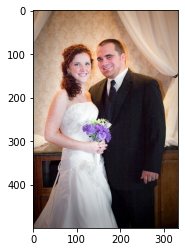

Referance Captions: 
A man and woman in a dark suit and formal white dress smile for a picture .
Predicted Caption: 
A man in a blue shirt be be stand on a street .
bleu score:  0.38715519446190366


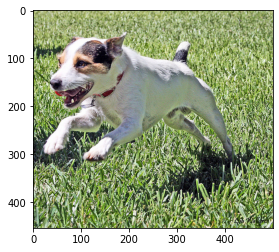

Referance Captions: 
A white dog wear a red collar be jump up from the grass .
A white dog with patch of brown and black on his eye be run through green grass .
White and brown dog with mouth open run on grass .
Predicted Caption: 
A dog be run through a beach .
bleu score:  0.3105179846875439


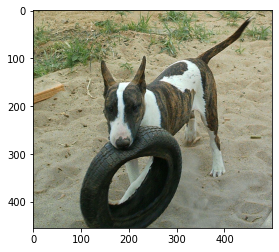

Referance Captions: 
A brown and white dog chew on a tire .
a brown , black and white dog hold a tire in its mouth while stand on sand
A dog stand in sand , hold a tire in his mouth .
A bull terrier terrorize an old tire in the sand .
Predicted Caption: 
A man be stand on a street .
bleu score:  0.5062667121584363


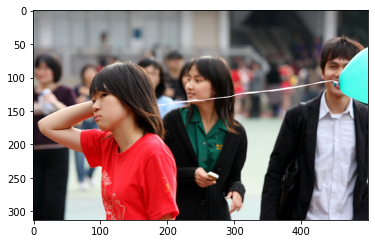

Referance Captions: 
A girl hold a blue balloon as she walk .
A girl in red shirt hold a green balloon in a crowd .
a Japanese girl carry a green balloon .
A girl be hold a blue balloon on a busy street .
An Asian boy in a red shirt hold onto an aqua balloon .
Predicted Caption: 
A man in a blue shirt be be stand on a street .
bleu score:  0.7115965735877551


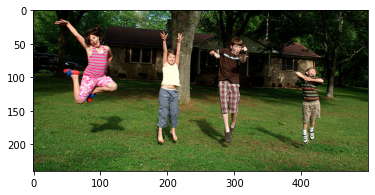

Referance Captions: 
Four child , out in a yard , leap into the air .
Four young kid have a picture take of them while in midair .
Two boy and two girl jump as they have their photo take .
Four kid be jump around and play outside .
Predicted Caption: 
A man in a blue shirt be be stand on a street .
bleu score:  0.4001601601922499


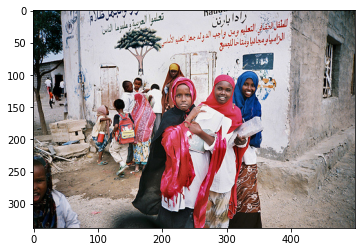

Referance Captions: 
Three woman be walk through a street in a rural Middle-eastern town .
Three girl with head wrap carry object while stand on unpaved surface .
There be three girl with head scarf in front of a wear down building and a family walk in the background .
Predicted Caption: 
A man in a blue shirt be be stand on a street .
bleu score:  0.6262844962765469


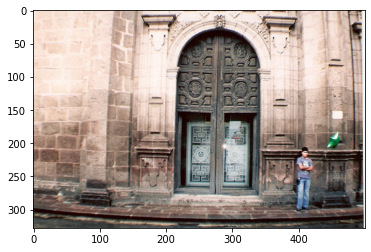

Referance Captions: 
A man with a green , star-shaped balloon be stand in front of a large building .
A man with a green star balloon stand to the side of the door of an ancient look building
A boy with a green balloon be stand outside of a large building .
Predicted Caption: 
A man in a blue shirt be be stand on a street .
bleu score:  0.5240124171055637


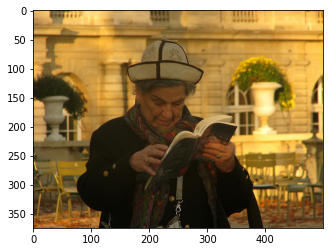

Referance Captions: 
An elderly person with a white hat be read a paperback book .
An elder woman in a hat and scarf be look through a book she have in her hand .
A woman in a white hat read a book .
An old woman wear a hat read a book .
An old lady consult a paperback book .
Predicted Caption: 
A man in a blue shirt be be stand on a street .
bleu score:  0.4428500142691474


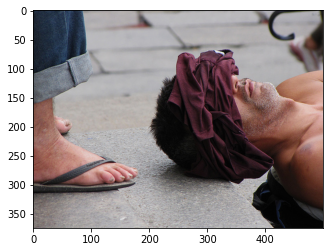

Referance Captions: 
A man on the pavement shield his eye with his t-shirt .
A man with a dark red shirt cover his face rest on the pavement near a person 's feet .
A man lie down with a maroon cloth over his eye and someone stand over him wear flip flop .
A man wear a maroon shirt tie around his face be lay on a cement
A man nap on the ground with a shirt over his eye with a person stand beside him .
Predicted Caption: 
A man in a blue shirt be be stand on a street .
bleu score:  0.5828233954152653


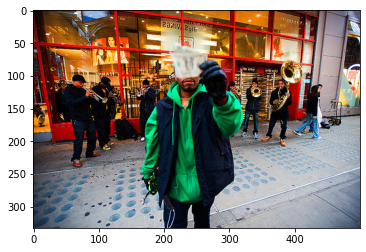

Referance Captions: 
A man hold money , stand in front of a street band and a store .
A man hold a dollar bill in front of his face while pose in front of a street band .
An African-american man wear a green sweatshirt and blue vest be hold up 2 dollar bill in front of his face , while stand on a busy sidewalk in front of a group of man play instrument .
A man hold money in the air .
Predicted Caption: 
A man in a blue shirt be be stand on a street .
bleu score:  0.3176962179326882


In [170]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==10):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [171]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)




















  7%|▋         | 163/2217 [01:28<19:36,  1.75it/s]


















  7%|▋         | 164/2217 [01:29<19:49,  1.73it/s]


















  7%|▋         | 165/2217 [01:29<20:07,  1.70it/s]


















  7%|▋         | 166/2217 [01:30<19:43,  1.73it/s]


















  8%|▊         | 167/2217 [01:30<19:28,  1.75it/s]


















  8%|▊         | 168/2217 [01:31<19:08,  1.78it/s]


















  8%|▊         | 169/2217 [01:31<19:17,  1.77it/s]


















  8%|▊         | 170/2217 [01:32<17:26,  1.96it/s]

KeyboardInterrupt: ignored

## Beam Search Function

In [172]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

## Predicting Captions on Test Set using Beam Search with k=3

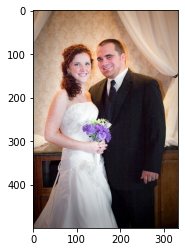

Referance Captions: 
A man and woman in a dark suit and formal white dress smile for a picture .
Predicted Caption: 
A man in a blue shirt and blue shirt and a blue shirt and a blue shirt and a red shirt and blue shirt and a red shirt and blue shirt and a black white black black black white white
bleu score:  0.31823566221963034


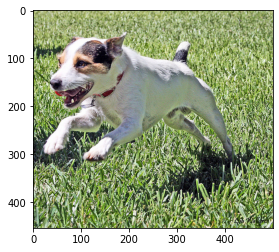

Referance Captions: 
A white dog wear a red collar be jump up from the grass .
A white dog with patch of brown and black on his eye be run through green grass .
White and brown dog with mouth open run on grass .
Predicted Caption: 
A black dog run through the grass .
bleu score:  0.355310106137518


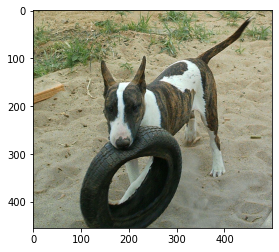

Referance Captions: 
A brown and white dog chew on a tire .
a brown , black and white dog hold a tire in its mouth while stand on sand
A dog stand in sand , hold a tire in his mouth .
A bull terrier terrorize an old tire in the sand .
Predicted Caption: 
A dog be stand on a beach .
bleu score:  0.5864047763647025


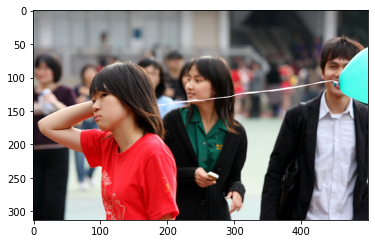

Referance Captions: 
A girl hold a blue balloon as she walk .
A girl in red shirt hold a green balloon in a crowd .
a Japanese girl carry a green balloon .
A girl be hold a blue balloon on a busy street .
An Asian boy in a red shirt hold onto an aqua balloon .
Predicted Caption: 
A man in a blue shirt and blue shirt and a blue shirt and a blue shirt and a red shirt and blue shirt and a red shirt and blue shirt and a black white black black black white white
bleu score:  0.14742205442586792


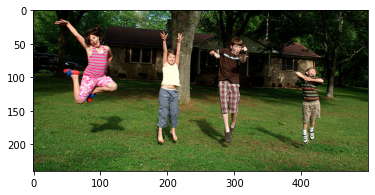

Referance Captions: 
Four child , out in a yard , leap into the air .
Four young kid have a picture take of them while in midair .
Two boy and two girl jump as they have their photo take .
Four kid be jump around and play outside .
Predicted Caption: 
A man in a blue shirt and blue shirt and a blue shirt and a blue shirt and a red shirt and blue shirt and a red shirt and blue shirt and a black white black black black white white
bleu score:  0.2094108425209914


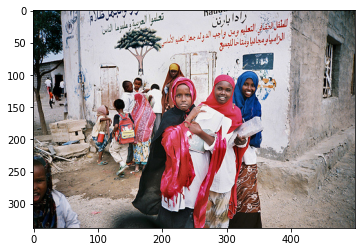

Referance Captions: 
Three woman be walk through a street in a rural Middle-eastern town .
Three girl with head wrap carry object while stand on unpaved surface .
There be three girl with head scarf in front of a wear down building and a family walk in the background .
Predicted Caption: 
A man in a blue shirt and blue shirt and a blue shirt and a blue shirt and a red shirt and blue shirt and a red shirt and blue shirt and a black white black black black white white
bleu score:  0.2676032275663791


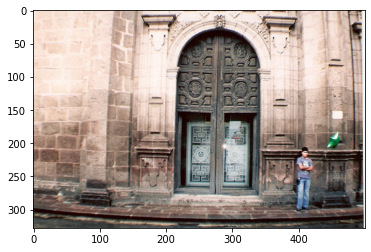

Referance Captions: 
A man with a green , star-shaped balloon be stand in front of a large building .
A man with a green star balloon stand to the side of the door of an ancient look building
A boy with a green balloon be stand outside of a large building .
Predicted Caption: 
A man in a blue shirt and blue shirt and a blue shirt and a blue shirt and a red shirt and blue shirt and a red shirt and blue shirt and a black white black black black white white
bleu score:  0.23793665482062618


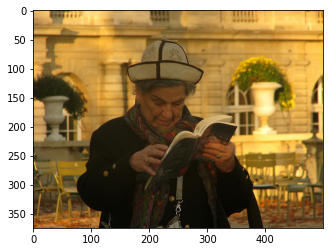

Referance Captions: 
An elderly person with a white hat be read a paperback book .
An elder woman in a hat and scarf be look through a book she have in her hand .
A woman in a white hat read a book .
An old woman wear a hat read a book .
An old lady consult a paperback book .
Predicted Caption: 
A man in a blue shirt and blue shirt and a blue shirt and a blue shirt and a red shirt and blue shirt and a red shirt and blue shirt and a black white black black black white white
bleu score:  0.24903286388467735


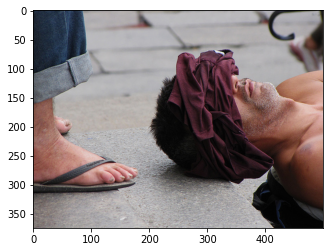

Referance Captions: 
A man on the pavement shield his eye with his t-shirt .
A man with a dark red shirt cover his face rest on the pavement near a person 's feet .
A man lie down with a maroon cloth over his eye and someone stand over him wear flip flop .
A man wear a maroon shirt tie around his face be lay on a cement
A man nap on the ground with a shirt over his eye with a person stand beside him .
Predicted Caption: 
A man in a blue shirt and blue shirt and a blue shirt and a blue shirt and a red shirt and blue shirt and a red shirt and blue shirt and a black white black black black white white
bleu score:  0.30778741582971547


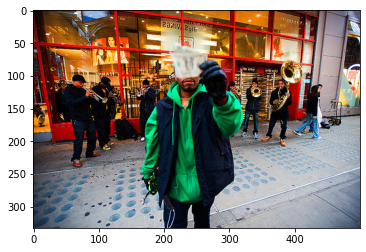

Referance Captions: 
A man hold money , stand in front of a street band and a store .
A man hold a dollar bill in front of his face while pose in front of a street band .
An African-american man wear a green sweatshirt and blue vest be hold up 2 dollar bill in front of his face , while stand on a busy sidewalk in front of a group of man play instrument .
A man hold money in the air .
Predicted Caption: 
A man in a blue shirt and blue shirt and a blue shirt and a blue shirt and a red shirt and blue shirt and a red shirt and blue shirt and a black white black black black white white
bleu score:  0.3521856535823236


In [174]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==10):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 2/1000 [00:02<24:45,  1.49s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 5/1000 [00:11<39:03,  2.35s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [37:52<00:00,  1.94s/it]

Bleu score on Beam search with k=3
Score:  0.48361032717611957
